[*********************100%***********************]  1 of 1 completed
Epoch 1/100
85/85 [==============================] - 14s 85ms/step - loss: 0.0148 - val_loss: 0.0230
Epoch 2/100
85/85 [==============================] - 6s 68ms/step - loss: 0.0031 - val_loss: 0.0079
Epoch 3/100
85/85 [==============================] - 6s 66ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 4/100
85/85 [==============================] - 6s 65ms/step - loss: 0.0025 - val_loss: 0.0108
Epoch 5/100
85/85 [==============================] - 6s 67ms/step - loss: 0.0024 - val_loss: 0.0064
Epoch 6/100
85/85 [==============================] - 6s 66ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 7/100
85/85 [==============================] - 6s 69ms/step - loss: 0.0022 - val_loss: 0.0071
Epoch 8/100
85/85 [==============================] - 6s 74ms/step - loss: 0.0019 - val_loss: 0.0129
Epoch 9/100
85/85 [==============================] - 6s 71ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 10/100
85/85 [==========

85/85 [==============================] - 6s 74ms/step - loss: 7.1184e-04 - val_loss: 0.0020
Epoch 80/100
85/85 [==============================] - 7s 79ms/step - loss: 7.6248e-04 - val_loss: 6.2524e-04
Epoch 81/100
85/85 [==============================] - 6s 76ms/step - loss: 6.6267e-04 - val_loss: 0.0029
Epoch 82/100
85/85 [==============================] - 6s 70ms/step - loss: 6.5851e-04 - val_loss: 0.0019
Epoch 83/100
85/85 [==============================] - 6s 72ms/step - loss: 7.2546e-04 - val_loss: 0.0011
Epoch 84/100
85/85 [==============================] - 6s 75ms/step - loss: 6.8952e-04 - val_loss: 0.0024
Epoch 85/100
85/85 [==============================] - 6s 68ms/step - loss: 6.7084e-04 - val_loss: 0.0037
Epoch 86/100
85/85 [==============================] - 6s 71ms/step - loss: 6.6435e-04 - val_loss: 0.0055
Epoch 87/100
85/85 [==============================] - 6s 68ms/step - loss: 7.1943e-04 - val_loss: 0.0036
Epoch 88/100
85/85 [==============================] - 6s 72ms/st

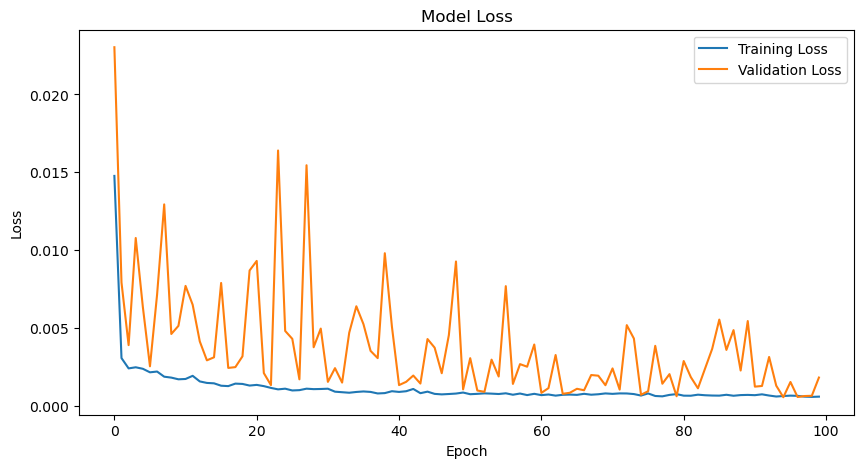

[*********************100%***********************]  1 of 1 completed
5/5 [==============================] - 1s 18ms/step


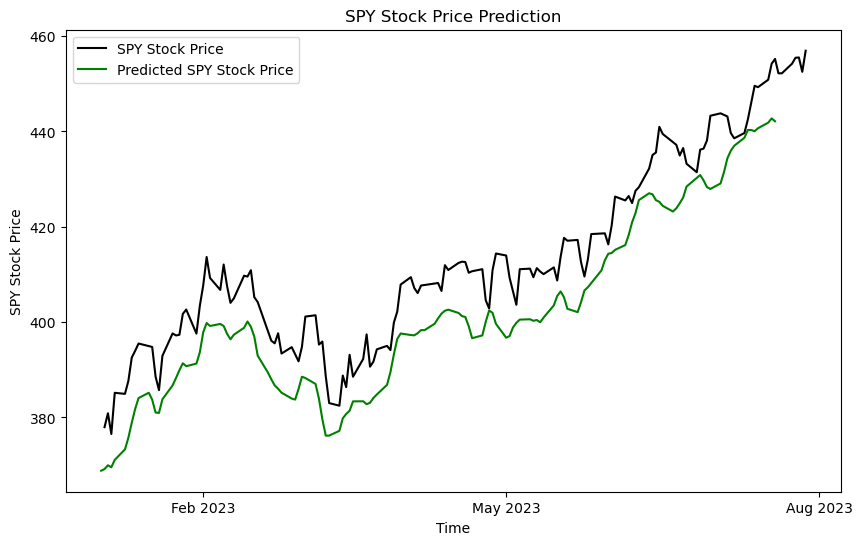

In [1]:
# Importing required libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import matplotlib.dates as mdates

# Download historical data for SPY from Yahoo Finance
spy = yf.download('SPY', start='2010-01-01', end='2023-01-01')

# Split data into training (2010-2020) and validation (2020-2023) sets
training_data = spy['Adj Close']['2010-01-01':'2020-12-31']
validation_data = spy['Adj Close']['2021-01-01':'2023-01-01']

# Use 'Adj Close' prices as the stock price for training
training_set = training_data.values.reshape(-1, 1)
validation_set = validation_data.values.reshape(-1, 1)

# Feature scaling using MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = sc.fit_transform(training_set)
validation_set_scaled = sc.transform(validation_set)


# Creating input sequences for training
def create_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(training_set_scaled)
X_validation, y_validation = create_sequences(validation_set_scaled)

# Reshape inputs for LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_validation = np.reshape(X_validation, (X_validation.shape[0], X_validation.shape[1], 1))


# Building the LSTM Model
model = keras.Sequential()
model.add(keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50, return_sequences=True))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.LSTM(units=50))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units=1))


# Compiling the LSTM Model
model.compile(optimizer='adam', loss='mean_squared_error')

# Training the Model and store history
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_validation, y_validation))


# Plot loss and accuracy during training
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Download test data for SPY from Yahoo Finance
spy_test = yf.download('SPY', start='2023-01-01', end='2023-07-31')

# Use 'Adj Close' prices as the test data
real_stock_price = spy_test['Adj Close'].values.reshape(-1, 1)


# Preparing Test Data
dataset_total = pd.concat((spy['Adj Close'], spy_test['Adj Close']), axis=0)
inputs = dataset_total[len(dataset_total) - len(spy_test) - 60:].values
inputs = inputs.reshape(-1, 1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


# Making Predictions
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Prepare dates for the predicted stock prices
date_range = pd.date_range(start='2023-01-01', periods=len(predicted_stock_price), freq='B')  # 'B' for business day frequency

# Visualizing Results with Month and Year on X-axis
plt.figure(figsize=(10, 6))
plt.plot(spy_test.index, real_stock_price, color='black', label='SPY Stock Price')
plt.plot(date_range, predicted_stock_price, color='green', label='Predicted SPY Stock Price')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Show tick marks for every 3 months
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format x-axis labels as 'Jan 2023', 'Feb 2023', etc.
plt.title('SPY Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('SPY Stock Price')
plt.legend()
plt.show()
